In [ ]:
!pip install deberta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.7 MB/s 
     |████████████████████████████████| 45 kB 2.7 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 1.2 MB 9.1 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=1ade6fbed563ee424bdce81dddcaa49d0ab9496c642b473a004a23b1af3026fb
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
! pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 35.3 MB/s 
     |████████████████████████████████| 6.6 MB 76.6 MB/s 
     |████████████████████████████████| 596 kB 93.1 MB/s 
     |████████████████████████████████| 101 kB 11.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
filepath = '/content/drive/MyDrive/cs542/'

Mounted at /content/drive


In [ ]:
import pandas as pd
from transformers import AutoTokenizer
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import numpy as np
import time
import datetime
import random
from transformers import AutoConfig, AutoModelForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

**Reading in the train and test preprocessed files**

In [ ]:
df_train = pd.read_csv(filepath+'TrainProcessed.csv')
df_test = pd.read_csv(filepath+'TestProcessed.csv')

**Converting the preprocessed train and test files from a list of words to strings.**

In [ ]:
def replace_symbols(df_list):
  updated_list = []
  for each_list in df_list:
    temp = each_list.replace(',', '')
    temp = temp.replace('[','')
    temp = temp.replace(']','')
    temp = temp.replace("'",'')
    temp = temp.replace(' s ',' ')

    updated_list.append(temp)
  return updated_list

In [ ]:
df_train_text = replace_symbols(df_train.Text_proc)
df_train_title = replace_symbols(df_train.Title_proc)

In [ ]:
df_test_text = replace_symbols(df_test.Text_proc)
df_test_title = replace_symbols(df_test.Title_proc)

**Converting the T and F labels to 1 and 0's respectively.**

In [ ]:
df_train_label = df_train.Label.eq('T').mul(1) ##Convert T to 1 and F to 0

In [ ]:
df_test_label = df_test.Label.eq('T').mul(1) ##Convert T to 1 and F to 0

**Combining both title and text to be used as input to the model.**

In [ ]:
sentences_train_mdeberta = []
for i in range(len(df_train_text)):
  sentences_train_mdeberta.append(df_train_text[i] + ' ' + df_train_title[i])

In [ ]:
labels_train_mdeberta = df_train_label

**Initializing the auto tokenizer for mDeBERTa**

In [ ]:
checkpoint = 'microsoft/mdeberta-v3-base'
tokenizer_mdeberta = AutoTokenizer.from_pretrained(checkpoint, do_lower_case=True)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/579 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.11M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


**Checking if GPU is available**

In [ ]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


**Converting the input text to inputids of max length 80**

In [ ]:
def mdeberta_train(tokenizer,training_set,train_labels):
  input_ids = []
  attention_masks = []
  token_type_ids=[]

  for sent1 in training_set:
    encoded_dict = tokenizer(
                        sent1,                   
                        add_special_tokens = True, 
                        max_length = 80,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',    
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    
    attention_masks.append(encoded_dict['attention_mask'])
    token_type_ids.append(encoded_dict['token_type_ids'])

  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  token_type_ids = torch.cat(token_type_ids, dim=0)
  labels = torch.tensor(train_labels)

  print('Original: ', training_set[0])
  print('Token IDs:', input_ids[0])
  return input_ids,attention_masks,labels

In [ ]:
input_ids_mdeberta,attention_masks_mdeberta,labels_mdeberta = mdeberta_train(tokenizer_mdeberta,sentences_train_mdeberta,labels_train_mdeberta)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  back television station register foreign agent editor chief say confirm later day intelligence agency say report television station broadcast cable state run propaganda machine contribute campaign interfere year presidential election favor candidate report insist comply registration requirement act require disclose financial information repeatedly deny allegation election meddling say view action unfriendly act editor chief say comply demand order avoid legal action government criminal case registration choose congratulate american freedom speech believe say confirm receive registration operate studio hire pay employee produce english language programming right know act influence government public behalf foreign principal say act announce long allow advertisement back news organization cite intelligence television station participate effort influence election require foreign government political party lobbyist public relation firm hire register pass lead effort combat german

**Splitting the train data into train and validation sets** 

In [ ]:
def datasetsize(input_ids, attention_masks, labels):
  dataset = TensorDataset(input_ids, attention_masks, labels)

  train_size = int(0.9 * len(dataset))
  val_size = len(dataset) - train_size

  train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

  print('{:>5,} training samples'.format(train_size))
  print('{:>5,} validation samples'.format(val_size)) 
  return train_dataset,val_dataset

def dataloader(size,train_dataset,val_dataset):
  batch_size = size
 
  train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size, 
            drop_last=True
        )
  validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size, 
            drop_last=True
        )
  return train_dataloader, validation_dataloader

In [ ]:
train_dataset_mdeberta,val_dataset_mdeberta = datasetsize(input_ids_mdeberta,attention_masks_mdeberta,labels_mdeberta)

36,368 training samples
4,041 validation samples


In [ ]:
train_dataloader_mdeberta, validation_dataloader_mdeberta = dataloader(32,train_dataset_mdeberta,val_dataset_mdeberta)

**Initializing the model for mDeBERTa Classification with number of labels as 2.**

In [ ]:
model_mdeberta_fake = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/mdeberta-v3-base", 
    num_labels = 2, 
    output_attentions = False, 
    output_hidden_states = False, 

)

model_mdeberta_fake.cuda()

Downloading:   0%|          | 0.00/534M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/mdeberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(251000, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0): DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
 

**Using the AdamW optimizer with a learning rate of 0.00002 and the scheduler**

In [ ]:
def optimizer_adamw(model):
  optimizer_adamw = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )
  return optimizer_adamw

def scheduler(train_dataloader,optimizer_adamw):
  epochs = 4

  total_steps = len(train_dataloader) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer_adamw, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps) 
  return scheduler

In [ ]:
optimizer_mdeberta = optimizer_adamw(model_mdeberta_fake)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
scheduler_mdeberta = scheduler(train_dataloader_mdeberta,optimizer_mdeberta)

**Function to help calculate the Accuracy score**

In [ ]:
def accuracy_calc(preds, labels):
    val_pred = np.argmax(preds, axis=1).flatten()
    val_lab = labels.flatten()
    return np.sum(val_pred == val_lab) / len(val_lab)

def return_str_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

**Training the dataset**

In [ ]:
def modeltraining(model,train_dataloader,validation_dataloader,optimizer,scheduler):

  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  training_stats = []

  total_t0 = time.time()
  epochs = 4

  for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 100 == 0 and not step == 0:
            elapsed = return_str_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    torch.save(model,'/content/drive/MyDrive/cs542/mdberta_models'+str(epoch_i)+'.pt')
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    training_time = return_str_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        
        logits = result.logits
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += accuracy_calc(logits, label_ids)
        

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = return_str_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(return_str_time(time.time()-total_t0)))
  return model, training_stats

In [ ]:
model_mdeberta_fake, training_stats = modeltraining(model_mdeberta_fake,train_dataloader_mdeberta,validation_dataloader_mdeberta,optimizer_mdeberta,scheduler_mdeberta)


======== Epoch 1 / 4 ========
Training...
  Batch   100  of  1,136.    Elapsed: 0:00:38.
  Batch   200  of  1,136.    Elapsed: 0:01:17.
  Batch   300  of  1,136.    Elapsed: 0:01:55.
  Batch   400  of  1,136.    Elapsed: 0:02:34.
  Batch   500  of  1,136.    Elapsed: 0:03:12.
  Batch   600  of  1,136.    Elapsed: 0:03:50.
  Batch   700  of  1,136.    Elapsed: 0:04:29.
  Batch   800  of  1,136.    Elapsed: 0:05:07.
  Batch   900  of  1,136.    Elapsed: 0:05:45.
  Batch 1,000  of  1,136.    Elapsed: 0:06:24.
  Batch 1,100  of  1,136.    Elapsed: 0:07:02.

  Average training loss: 0.05
  Training epcoh took: 0:07:20

Running Validation...
  Accuracy: 0.98
  Validation Loss: 0.13
  Validation took: 0:00:14

======== Epoch 2 / 4 ========
Training...
  Batch   100  of  1,136.    Elapsed: 0:00:38.
  Batch   200  of  1,136.    Elapsed: 0:01:17.
  Batch   300  of  1,136.    Elapsed: 0:01:55.
  Batch   400  of  1,136.    Elapsed: 0:02:33.
  Batch   500  of  1,136.    Elapsed: 0:03:12.
  Batch  

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

**Display table of training and validation loss and accuracy.**

In [ ]:
import pandas as pd
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.05,0.13,0.98,0:07:20,0:00:14
2,0.04,0.12,0.97,0:07:19,0:00:14
3,0.02,0.13,0.98,0:07:19,0:00:14
4,0.01,0.13,0.98,0:07:19,0:00:14


**Display graph of training and validation loss vs the number of epochs.**

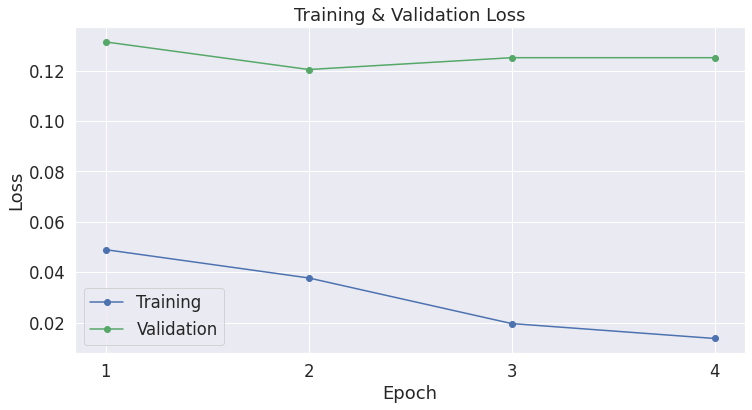

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

**Predicting on test data**

**Combing both the title and text features similar to what we did for** **the train dataset.**

In [ ]:
test_sentences_mdeberta = []
for i in range(len(df_test_text)):
  test_sentences_mdeberta.append(df_test_text[i] + ' ' + df_test_title[i])

In [ ]:
test_labels_mdeberta = df_test_label

In [ ]:
def fake_test_preprocessing(test_sentences,test_labels, tokenizer, batchsize,maxlength):
  input_ids_test,attention_masks_test,labels_test = mdeberta_train(tokenizer,test_sentences,test_labels)
  batch_size = batchsize 
  prediction_data = TensorDataset(input_ids_test, attention_masks_test, labels_test)
  prediction_sampler = SequentialSampler(prediction_data)
  prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

  return prediction_dataloader

def fake_predict(model,prediction_dataloader):
  model.eval()
  predictions , true_labels = [], []
  total_eval_accuracy = 0
  act_pred_label = []
  act_true_labels = []
  for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():

      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

    logits = result.logits

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    total_eval_accuracy += accuracy_calc(logits, label_ids)
  
    predictions.append(logits)
    true_labels.append(label_ids)
    predict_content = logits.argmax(axis=-1).flatten().tolist()
    act_pred_label += predict_content
    act_true_labels += label_ids.flatten().tolist()

  return total_eval_accuracy*100/len(prediction_dataloader), act_pred_label,act_true_labels

**Preprocessing the test data with batch size of 32 and max length of each input as 80**

In [ ]:
dataloader_mdeberta_test = fake_test_preprocessing(test_sentences_mdeberta,test_labels_mdeberta,tokenizer_mdeberta,32,80)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  lobbyist lead business huddle spring state map campaign enact statewide lgbt anti discrimination law record number republican lawmaker throw support propose protection lesbian gay bisexual transgender people hundred company back cause bill far fall short time run legislative session lead backer hearten progress determine retool year definitely need ramp grassroot say lobbyist group state business support lgbt protection lot agree policy worried effect home year transgender bathroom access erupt culture war flashpoint conservative statehouse activist momentum building affirmative legislation nation populous state offer breakthrough national movement advance lgbt civil right protection view advocate stepping stone ultimate goal federal anti discrimination law state concentrate law fully guard people fire job kick housing deny service restaurant hotel business fight continue ruling legalize sex marriage nationally strategy year making aim build bipartisan support economic argum

**We loaded the saved model for epoch 2 as that was where the lowest validation loss was.**

In [ ]:
model_loaded = torch.load('/content/drive/MyDrive/cs542/mdberta_models1.pt') ##choose based on which epoch - this is second epoch

**Running the prediction function to retrieve the y hat and accuracy**

In [ ]:
acc_test, pred_label_test, true_labels_test = fake_predict(model_loaded,dataloader_mdeberta_test)

**Accuracy**

In [ ]:
acc_test

97.56205673758865

**Perfomance Metrics**

In [ ]:
precision = precision_score(pred_label_test, true_labels_test)
print('Precision: ', precision)

Precision: 0.990659


In [ ]:
f1 = f1_score(pred_label_test, true_labels_test)
print('F1 score: ', f1)

F1 score: 0.974724


In [ ]:
recallscore = recall_score(pred_label_test, true_labels_test)
print('Recall score: ', recallscore)

Recall score: 0.959294


**Confusion Matrix**

In [ ]:
matrix_mdeberta = confusion_matrix(true_labels_test, pred_label_test)

print(matrix_mdeberta)

[[2258   90]
 [  20 2121]]


**Display heatmap of confusion matrix**

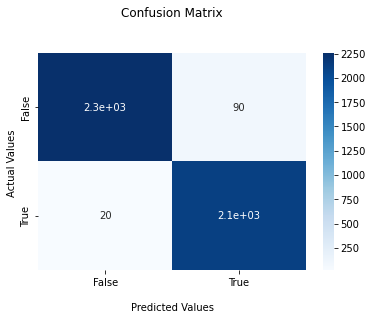

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
ax = sns.heatmap(matrix_mdeberta, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()